## Protein sequence embedding using Doc2Vec

Firstly, let's see how the sequence-structured data, like language, is modeled with neural networks. 

Word2Vec is a well known concept, intends to generate a numeric representation for each word, that will be able to capture the word context similarity or transfer the relations like "man is to woman as king is to queen".

Doc2Vec is less known but also frequently used in nature language processing for learning fixed-length representations from variable-length pieces of texts, such as sentences, paragraphs, and documents.

Here we would like to encode protein sequences with the idea of Doc2Vec. 

In [2]:
!pip install gensim

    100% |████████████████████████████████| 24.2MB 2.5MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 32.2MB/s ta 0:00:01
    100% |████████████████████████████████| 1.4MB 24.4MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 40.3MB/s ta 0:00:01
    100% |████████████████████████████████| 5.5MB 9.4MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 30.5MB/s ta 0:00:01
    100% |████████████████████████████████| 552kB 25.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /root/.cache/pip/wheels/5f/ea/fb/5b1a947b369724063b2617011f1540c44eb00e28c3d2ca8692
Successfully built smart-open
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
# %env PYTHONHASHSEED=0
import pickle
import multiprocessing
import random
import os

import numpy as np
import pandas as pd
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from heatmapcluster import heatmapcluster
from scipy.cluster.hierarchy import linkage
%config InlineBackend.figure_format = 'svg'


### Model
#### Building the Vocabulary Table
Doc2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them). The words of protein sequence language can be 20 amino acids or combinations of two or three amino acides. Intuitively, if 20 amino acids represent a word individually, then the "language" of protein sequences has 20 vocabulary. Combining two amino acids as the words of protein sequence will contribute to about 400 vocabulary, and combining 3 amino acids contributs to about 8000 vocabulary, and so on. So how many amino acids should be combined as the "word" of protein "language" has yet to decide.
We can try from 1 to 4, larger than 4 would contribute to too much vocabulary, which may not be appropriate rom the model to learn.

In [5]:
# to keep the fidelity of embeddings after subtle insertions or deletions, two adjacent words are overlapped
def seq_to_kmers(seq, k=3, overlap=True):
    if overlap:
        kmer = [[seq[i:i+k] for i in range(len(seq) - k + 1)]]
        return kmer
    else:
        kmer = [[seq[i:i+k] for i in range(j, len(seq) - k + 1, k)] for j in range(k)]
        return kmer

def combine(vectors, k):
    embeddings = np.zeros((vectors.shape[0] // k, vectors.shape[1]))
    for i in range(k):
        embeddings += vectors[i::k, :]
    return embeddings


In [6]:
class Corpus(object):
    # generate coropus, such as 2-mer 'DF' or 3-mer 'DFG'
    def __init__(self, df,  k=3, overlap=True):
        self.df = df
        self.k = k
        self.overlap = overlap

    def __iter__(self):
        for seq in self.whole_seq():
            yield seq

    def df_to_kmers(self):
        for seq in self.df.Sequence.values:
            kmers = seq_to_kmers(seq,  k=self.k, overlap=self.overlap)
            for km in kmers:
                yield km

    def whole_seq(self):
        return (TaggedDocument(seq, [symbol]) for symbol,seq in zip(self.df.kinase.values, self.df_to_kmers()))


#### Training the model
Combining 1 to 4 consecutive amino acids as the vocabulary, each combining size trains a indepedent model. Later we will decide which one is best.
The model is trained with PV-DBOW algorithm that is initial introduced to learn a embedding for a whole paragraph by the same team form Google that coined the concept of 'word embedding'([original paper](https://arxiv.org/pdf/1405.4053.pdf)). Distributed Bag of Words version of Paragraph Vector (PV-DBOW) ignore the context
words in the input, but force the model to predict words randomly sampled from the paragraph in the output. In reality, what this means is that at each iteration of stochastic gradient descent, we sample a text window, then sample a random word from the text window and form a classification task given the Paragraph Vector. This technique is shown as follows: <img src="img/protein_embedding_scheme.jpg" width=800>

In [8]:
for k in range(1,5):
    kinase_seq = pd.read_csv('../data/all-kinase-100-5000.csv')
    model_params = {'vector_size': 100,
                    'min_count': 0,
                    'epochs': 50,
                    'dbow_words':1,
                    'seed':8,
                    'dm':0,
                    'workers': 8}
    seq_corpus =Corpus(kinase_seq, k=2, overlap=True)
    model = Doc2Vec(**model_params)
    model.build_vocab(seq_corpus)
    %time model.train(seq_corpus,epochs=model.epochs, total_examples=model.corpus_count)
    model.save('../data/overlap_kinase_'+str(k)+'_50.pickle')

CPU times: user 1h 21min 9s, sys: 17.7 s, total: 1h 21min 27s
Wall time: 22min


/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 1h 20min 42s, sys: 17.4 s, total: 1h 21min
Wall time: 21min 52s


/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 1h 20min 27s, sys: 16.1 s, total: 1h 20min 43s
Wall time: 21min 46s


/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 1h 20min 34s, sys: 16.7 s, total: 1h 20min 51s
Wall time: 21min 50s


/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Inspecting the model
Let's see what our model gives. It seems that it has kind of understood the protein sequence good, since the most similar sequences to CDK6_HUMAN pertain to same family. This is really awesome (and important), since the generated protein sequences embeddings capture the sequence similiarity well.

In [8]:
model = Doc2Vec.load('../data/overlap_kinase_2_50.pickle')
seq_sims = model.docvecs.most_similar([model['CDK6_HUMAN']], topn=8)
print(seq_sims)

[('CDK6_HUMAN', 0.9999999403953552), ('CDK6_MOUSE', 0.9439486265182495), ('CDK2_MOUSE', 0.6838136315345764), ('CDK4_XENLA', 0.6518393158912659), ('CDK1_EMENI', 0.5890960693359375), ('CDK3_HUMAN', 0.5865243673324585), ('CDK4_HUMAN', 0.5768906474113464), ('CDK3_MOUSE', 0.5724563598632812)]


#### Infering embedding for  new sequences
Since the training and infering are dependent on some randomized choices and approximations, there's no single 'right' vector for particular inputs, but we need the vectors are stable enough in different runs. Therefore, for each new protein sequence, the embedding was generated by averaging the result of 100 indepent infering runs.

In [10]:
def get_embeddings(seqs, k=2, overlap=True):
    seq_kmers = []
    for seq in seqs:
        seq_kmers += seq_to_kmers(seq, k=k, overlap=overlap)
    embeddings = 0
    for _ in range(100):
        embeddings += np.array([model.infer_vector(seq) for seq in seq_kmers])

#     embeddings = normalize_by_norm(embeddings)
    embeddings = embeddings/100
    
    if overlap:
        embeddings = embeddings
    else:
        embeddings = combine(embeddings, k)

    return embeddings

model = Doc2Vec.load('../data/overlap_kinase_2_50.pickle')
human_kinase_seq = pd.read_csv('../data/human_kinase_seq.csv')

seqs = human_kinase_seq.Sequence.values
seq_embeddings = get_embeddings(seqs, k=2, overlap=True)

human_kinase_seq['embedding'] = [list(embedding) for embedding in list(seq_embeddings)]


/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [34]:
kinase_ids = pd.read_csv('../data/kinase_ids.csv')
mapped_id = {}

for kinase in human_kinase_seq.kinase.values:
    for names in kinase_ids['Gene names']: 
        if kinase.upper() in names.split(' '):
            mapped_id[kinase] = names.split(' ')[0]
#     if kinase not in mapped_id.keys():
#         print(kinase)
        
mapped_id['PDK1'] = 'PDPK1'
mapped_id['PAK5'] = 'PAK5'
mapped_id['NIK'] = 'MAP3K14'
for old, new in mapped_id.items():
    human_kinase_seq.loc[human_kinase_seq['kinase']==old,['kinase']] = new
saved_embedding_name = '../data/kinase_seq_embedding_2.csv'
human_kinase_seq.to_csv(saved_embedding_name, index=False)

In [4]:
def draw_phylogenetic_tree(data_file):
    kinase_seq_embedding = pd.read_csv(data_file)
    seq_embeddings= [kinase_seq_embedding.loc[kinase_seq_embedding['kinase']==kinase].embedding.values[0] \
                     for kinase in gene_name]

    seq_embeddings = np.array([float(x) for embedding in seq_embeddings for x in embedding \
                      .replace("[", "").replace("]", "").replace(",", "").split(' ')]).reshape(len(row_name),-1)
    column_name = ['%i' % i for i in range(seq_embeddings.shape[1])]

    # print(seq_embeddings.shape)
    h = heatmapcluster(seq_embeddings, row_name, column_name,                   
                       label_fontsize=8,
                       xlabel_rotation=-90,
                       figsize=(12, 4),
                       cmap=plt.cm.coolwarm,
                       show_colorbar=True,
    #                    colorbar_pad=0.8,
                       row_linkage=lambda x: linkage(x, method='single',
                                                     metric='euclidean'),
                       top_dendrogram=False,
                       histogram=True)


<Figure size 1800x1200 with 0 Axes>

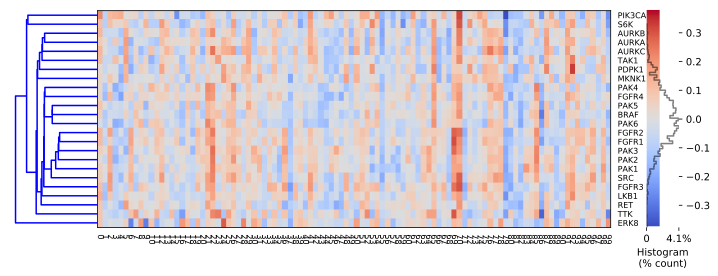

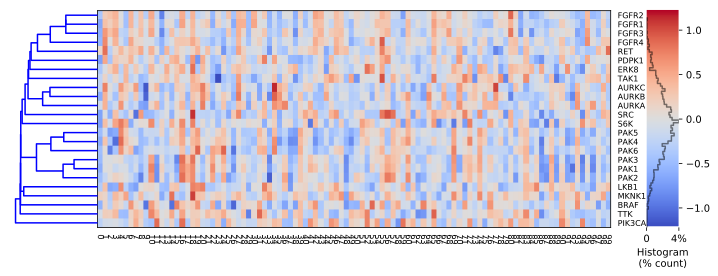

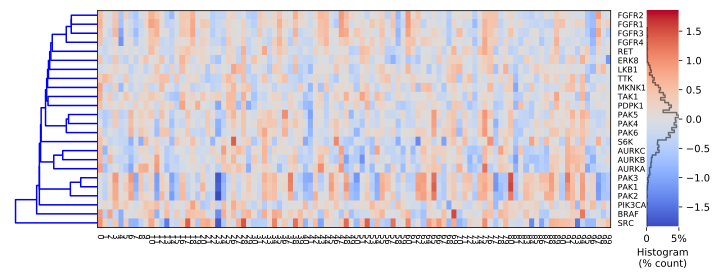

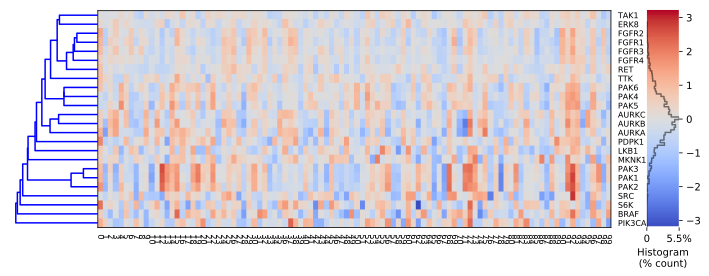

In [5]:
gene_name = ['BRAF','MAPK15','MKNK1','PDPK1','RET','RPS6KB1','SRC','TTK','AURKA','AURKB','AURKC',\
             'FGFR1','FGFR2','FGFR3','FGFR4','STK11','PAK1','PAK2','PAK3','PAK4','PAK5','PAK6','PIK3CA','MAP3K7']
row_name =  ['BRAF','ERK8','MKNK1','PDPK1','RET','S6K','SRC','TTK','AURKA','AURKB','AURKC',\
             'FGFR1','FGFR2','FGFR3','FGFR4','LKB1','PAK1','PAK2','PAK3','PAK4','PAK5','PAK6','PIK3CA','TAK1']
    
plt.figure(dpi=300)
plt.show()
data_file = '../data/kinase_seq_embedding_1.csv'
draw_phylogenetic_tree(data_file)
data_file = '../data/kinase_seq_embedding_2.csv'
draw_phylogenetic_tree(data_file)
data_file = '../data/kinase_seq_embedding_3.csv'
draw_phylogenetic_tree(data_file)
data_file = '../data/kinase_seq_embedding_4.csv'
draw_phylogenetic_tree(data_file)


From the clustering results, we see the model combining two consecutive amino acids as words can generate embeddings that reproduce protein family similarity and divergent. However, the phylogenetic trees from sequence embeddings are not exactly the same, providing an new similarity measurement from the view of deep learning, totally different from statistial alignment scoring matrix such as BLOSUM and PAM.

In [9]:
# plot with seaborn, which is not good-looking
cluster_df = pd.DataFrame(seq_embeddings).transpose()
cluster_df.columns = name_list
cluster_df = cluster_df.transpose()
import seaborn as sns; sns.set(color_codes=True)
g = sns.clustermap(cluster_df, col_cluster=False)